# 含并行连结的网络（GoogLeNet）
:label:`sec_googlenet`

在2014年的ImageNet图像识别挑战赛中，一个名叫*GoogLeNet* :cite:`Szegedy.Liu.Jia.ea.2015`的网络架构大放异彩。
GoogLeNet吸收了NiN中串联网络的思想，并在此基础上做了改进。
这篇论文的一个重点是解决了什么样大小的卷积核最合适的问题。
毕竟，以前流行的网络使用小到$1 \times 1$，大到$11 \times 11$的卷积核。
本文的一个观点是，有时使用不同大小的卷积核组合是有利的。
本节将介绍一个稍微简化的GoogLeNet版本：我们省略了一些为稳定训练而添加的特殊特性，现在有了更好的训练方法，这些特性不是必要的。

## (**Inception块**)

在GoogLeNet中，基本的卷积块被称为*Inception块*（Inception block）。这很可能得名于电影《盗梦空间》（Inception），因为电影中的一句话“我们需要走得更深”（“We need to go deeper”）。

![Inception块的架构。](../img/inception.svg)
:label:`fig_inception`

如 :numref:`fig_inception`所示，Inception块由四条并行路径组成。
前三条路径使用窗口大小为$1\times 1$、$3\times 3$和$5\times 5$的卷积层，从不同空间大小中提取信息。
中间的两条路径在输入上执行$1\times 1$卷积，以减少通道数，从而降低模型的复杂性。
第四条路径使用$3\times 3$最大汇聚层，然后使用$1\times 1$卷积层来改变通道数。
这四条路径都使用合适的填充来使输入与输出的高和宽一致，最后我们将每条线路的输出在通道维度上连结，并构成Inception块的输出。在Inception块中，通常调整的超参数是每层输出通道数。


In [ ]:
%pip install d2l==1.0.3 --no-deps
%pip install scipy torch torchvision

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class Inception(nn.Module):
    # c1--c4是每条路径的输出通道数
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # 线路1，单1x1卷积层
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # 线路2，1x1卷积层后接3x3卷积层
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # 线路3，1x1卷积层后接5x5卷积层
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 线路4，3x3最大汇聚层后接1x1卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

        # 添加批量归一化层
        self.bn1 = nn.BatchNorm2d(c1)
        self.bn2 = nn.BatchNorm2d(c2[1])
        self.bn3 = nn.BatchNorm2d(c3[1])
        self.bn4 = nn.BatchNorm2d(c4)

    def forward(self, x):
        p1 = F.relu(self.bn1(self.p1_1(x)))
        p2 = F.relu(self.bn2(self.p2_2(F.relu(self.p2_1(x)))))
        p3 = F.relu(self.bn3(self.p3_2(F.relu(self.p3_1(x)))))
        p4 = F.relu(self.bn4(self.p4_2(self.p4_1(x))))
        # 在通道维度上连结输出
        return torch.cat((p1, p2, p3, p4), dim=1)

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

class InceptionV3Block(nn.Module):
    def __init__(self, in_channels, c1, c2, c3, c4):
        super().__init__()
        # 路径 1: 1x1 卷积
        self.p1_1 = nn.Sequential(nn.Conv2d(in_channels, c1, kernel_size=1), nn.BatchNorm2d(c1), nn.ReLU())
        
        # 路径 2: 1x1 卷积 -> 1x3 -> 3x1 (代替 3x3)
        self.p2_1 = nn.Sequential(nn.Conv2d(in_channels, c2[0], kernel_size=1), nn.BatchNorm2d(c2[0]), nn.ReLU())
        self.p2_2 = nn.Sequential(
            nn.Conv2d(c2[0], c2[1], kernel_size=(1, 3), padding=(0, 1)),
            nn.BatchNorm2d(c2[1]), nn.ReLU(),
            nn.Conv2d(c2[1], c2[1], kernel_size=(3, 1), padding=(1, 0)),
            nn.BatchNorm2d(c2[1]), nn.ReLU()
        )
        
        # 路径 3: 1x1 -> 两个 3x3 (代替 5x5)
        self.p3_1 = nn.Sequential(nn.Conv2d(in_channels, c3[0], kernel_size=1), nn.BatchNorm2d(c3[0]), nn.ReLU())
        self.p3_2 = nn.Sequential(
            nn.Conv2d(c3[0], c3[1], kernel_size=3, padding=1),
            nn.BatchNorm2d(c3[1]), nn.ReLU(),
            nn.Conv2d(c3[1], c3[1], kernel_size=3, padding=1),
            nn.BatchNorm2d(c3[1]), nn.ReLU()
        )
        
        # 路径 4: 最大汇聚 -> 1x1
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Sequential(nn.Conv2d(in_channels, c4, kernel_size=1), nn.BatchNorm2d(c4), nn.ReLU())

    def forward(self, x):
        p1 = self.p1_1(x)
        p2 = self.p2_2(self.p2_1(x))
        p3 = self.p3_2(self.p3_1(x))
        p4 = self.p4_2(self.p4_1(x))
        return torch.cat((p1, p2, p3, p4), dim=1)

那么为什么GoogLeNet这个网络如此有效呢？
首先我们考虑一下滤波器（filter）的组合，它们可以用各种滤波器尺寸探索图像，这意味着不同大小的滤波器可以有效地识别不同范围的图像细节。
同时，我们可以为不同的滤波器分配不同数量的参数。

## [**GoogLeNet模型**]

如 :numref:`fig_inception_full`所示，GoogLeNet一共使用9个Inception块和全局平均汇聚层的堆叠来生成其估计值。Inception块之间的最大汇聚层可降低维度。
第一个模块类似于AlexNet和LeNet，Inception块的组合从VGG继承，全局平均汇聚层避免了在最后使用全连接层。

![GoogLeNet架构。](../img/inception-full.svg)
:label:`fig_inception_full`

现在，我们逐一实现GoogLeNet的每个模块。第一个模块使用64个通道、$7\times 7$卷积层。


In [ ]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

第二个模块使用两个卷积层：第一个卷积层是64个通道、$1\times 1$卷积层；第二个卷积层使用将通道数量增加三倍的$3\times 3$卷积层。
这对应于Inception块中的第二条路径。


In [ ]:
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

第三个模块串联两个完整的Inception块。
第一个Inception块的输出通道数为$64+128+32+32=256$，四个路径之间的输出通道数量比为$64:128:32:32=2:4:1:1$。
第二个和第三个路径首先将输入通道的数量分别减少到$96/192=1/2$和$16/192=1/12$，然后连接第二个卷积层。第二个Inception块的输出通道数增加到$128+192+96+64=480$，四个路径之间的输出通道数量比为$128:192:96:64 = 4:6:3:2$。
第二条和第三条路径首先将输入通道的数量分别减少到$128/256=1/2$和$32/256=1/8$。


In [ ]:
b3 = nn.Sequential(InceptionV3Block(192, 64, (96, 128), (16, 32), 32),
                   InceptionV3Block(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

第四模块更加复杂，
它串联了5个Inception块，其输出通道数分别是$192+208+48+64=512$、$160+224+64+64=512$、$128+256+64+64=512$、$112+288+64+64=528$和$256+320+128+128=832$。
这些路径的通道数分配和第三模块中的类似，首先是含$3×3$卷积层的第二条路径输出最多通道，其次是仅含$1×1$卷积层的第一条路径，之后是含$5×5$卷积层的第三条路径和含$3×3$最大汇聚层的第四条路径。
其中第二、第三条路径都会先按比例减小通道数。
这些比例在各个Inception块中都略有不同。


In [ ]:
b4 = nn.Sequential(InceptionV3Block(480, 192, (96, 208), (16, 48), 64),
                   InceptionV3Block(512, 160, (112, 224), (24, 64), 64),
                   InceptionV3Block(512, 128, (128, 256), (24, 64), 64),
                   InceptionV3Block(512, 112, (144, 288), (32, 64), 64),
                   InceptionV3Block(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

第五模块包含输出通道数为$256+320+128+128=832$和$384+384+128+128=1024$的两个Inception块。
其中每条路径通道数的分配思路和第三、第四模块中的一致，只是在具体数值上有所不同。
需要注意的是，第五模块的后面紧跟输出层，该模块同NiN一样使用全局平均汇聚层，将每个通道的高和宽变成1。
最后我们将输出变成二维数组，再接上一个输出个数为标签类别数的全连接层。


In [ ]:
b5 = nn.Sequential(InceptionV3Block(832, 256, (160, 320), (32, 128), 128),
                   InceptionV3Block(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

GoogLeNet模型的计算复杂，而且不如VGG那样便于修改通道数。
[**为了使Fashion-MNIST上的训练短小精悍，我们将输入的高和宽从224降到96**]，这简化了计算。下面演示各个模块输出的形状变化。


In [ ]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


## [**训练模型**]

和以前一样，我们使用Fashion-MNIST数据集来训练我们的模型。在训练之前，我们将图片转换为$96 \times 96$分辨率。


loss 0.243, train acc 0.907, test acc 0.894
1162.3 examples/sec on cuda:0


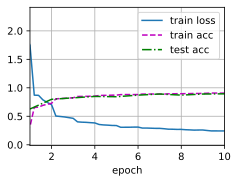

In [ ]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 小结

* Inception块相当于一个有4条路径的子网络。它通过不同窗口形状的卷积层和最大汇聚层来并行抽取信息，并使用$1×1$卷积层减少每像素级别上的通道维数从而降低模型复杂度。
*  GoogLeNet将多个设计精细的Inception块与其他层（卷积层、全连接层）串联起来。其中Inception块的通道数分配之比是在ImageNet数据集上通过大量的实验得来的。
* GoogLeNet和它的后继者们一度是ImageNet上最有效的模型之一：它以较低的计算复杂度提供了类似的测试精度。

## 练习

1. GoogLeNet有一些后续版本。尝试实现并运行它们，然后观察实验结果。这些后续版本包括：
    * 添加批量规范化层 :cite:`Ioffe.Szegedy.2015`（batch normalization），在 :numref:`sec_batch_norm`中将介绍；
    * 对Inception模块进行调整 :cite:`Szegedy.Vanhoucke.Ioffe.ea.2016`；
    * 使用标签平滑（label smoothing）进行模型正则化 :cite:`Szegedy.Vanhoucke.Ioffe.ea.2016`；
    * 加入残差连接 :cite:`Szegedy.Ioffe.Vanhoucke.ea.2017`。（ :numref:`sec_resnet`将介绍）。
1. 使用GoogLeNet的最小图像大小是多少？
1. 将AlexNet、VGG和NiN的模型参数大小与GoogLeNet进行比较。后两个网络架构是如何显著减少模型参数大小的？


[Discussions](https://discuss.d2l.ai/t/1871)


在 GoogLeNet 的哲学里，功能是解耦的：

* **$1 \times 1$卷积**：专门负责**控制通道数（瓶颈层）**和**引入非线性（ReLU）**。
* **$3 \times 3$卷积**：专门负责**提取空间特征（感受野）**。

如果你全用$3 \times 3$卷积来降维，它既干了“压缩”的活，又干了“提取空间特征”的活，这会让网络设计变得混乱。使用  能够让我们更纯粹地在增加网络深度的同时，控制住计算负担。

**第一问**  
这是原始googlenet运行的结果：  
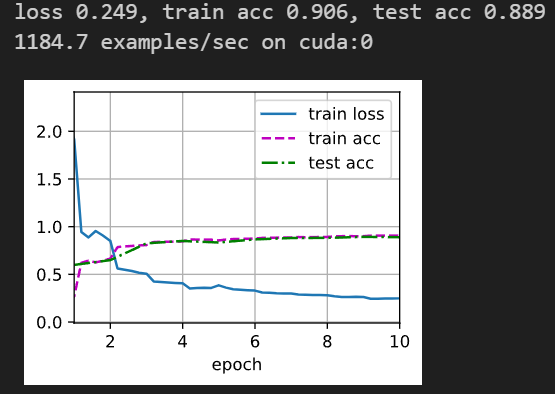  
添加批量规范化层后的结果：  
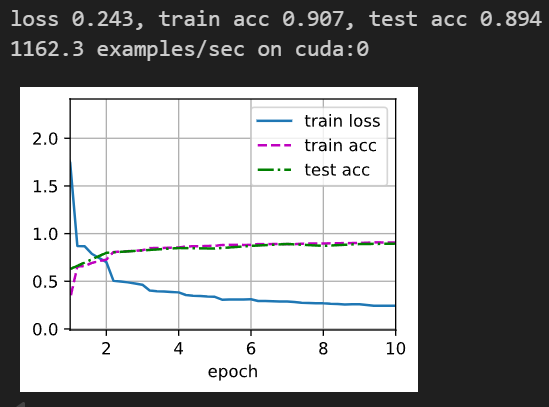  
使用InceptionV3后的结果：  
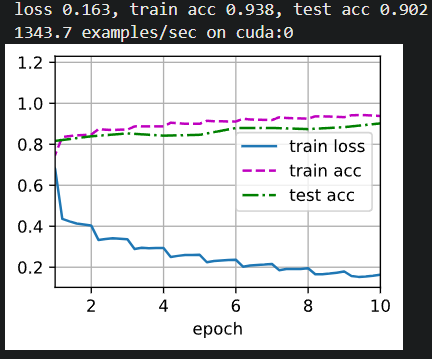  
使用标签平滑后的结果：  
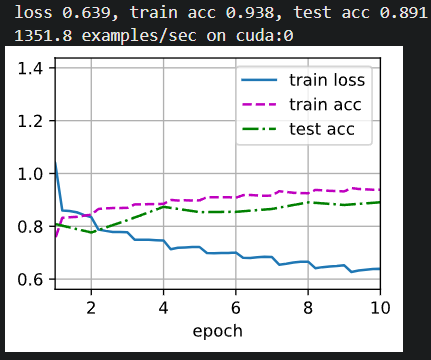  

**第二问**  
GoogLeNet 在整个前向传播过程中，共有 5 个层级会导致特征图尺寸减半（通过步幅为 2 的卷积或最大汇聚层）：

* **Stage 1**:  卷积 (stride 2)  缩小 1/2
* **Stage 2**:  汇聚 (stride 2)  缩小 1/2
* **Stage 3**:  汇聚 (stride 2)  缩小 1/2
* **Stage 4**:  汇聚 (stride 2)  缩小 1/2
* **Stage 5**: 在进入全局平均汇聚层（Global Average Pooling）之前，通常还有一次下采样。

如果输入是$32 \times 32$，经过 5 次减半，特征图将变为$1 \times 1$。如果输入小于$32 \times 32$，在到达最后一层之前，特征图的尺寸就会变成 0 或负数（报错）。  

**第三问**  
1. 用全局平均汇聚替代全连接层；
2. 利用 $1 \times 1$ 卷积控制通道厚度，避免参数随深度和核尺寸爆炸式增长。